# Demo on a single image pair from IMC-PT

In [1]:
import torch
from relscalenet.models.relscale_cache import load_image, extract_patches
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import poselib
from relscalenet import geometry
from relscalenet.models.relscale_cache import RelScaleNetCached
from relscalenet.visualization import MatchPlotter
from relscalenet.dataset_reader import EvaluationDataset

INLIER_THRESHOLD = 1.0

### Load data

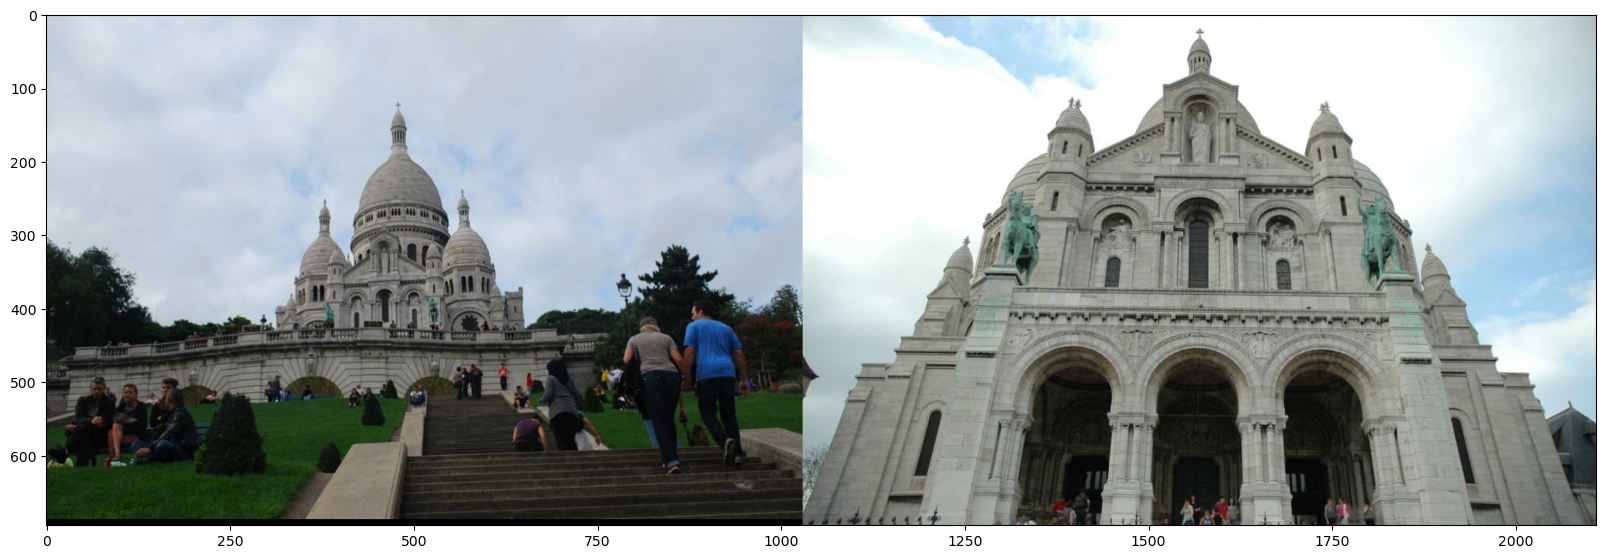

In [2]:
data_path = 'data/demo/demo.h5'
images_path = 'data/demo/images'
dataset = EvaluationDataset(data_path, images_path)
image_pair = dataset[0]

im1_path, im2_path = image_pair.image_paths()
plotter = MatchPlotter(im1_path, im2_path)
plotter.draw_images()

### Read tentative matches

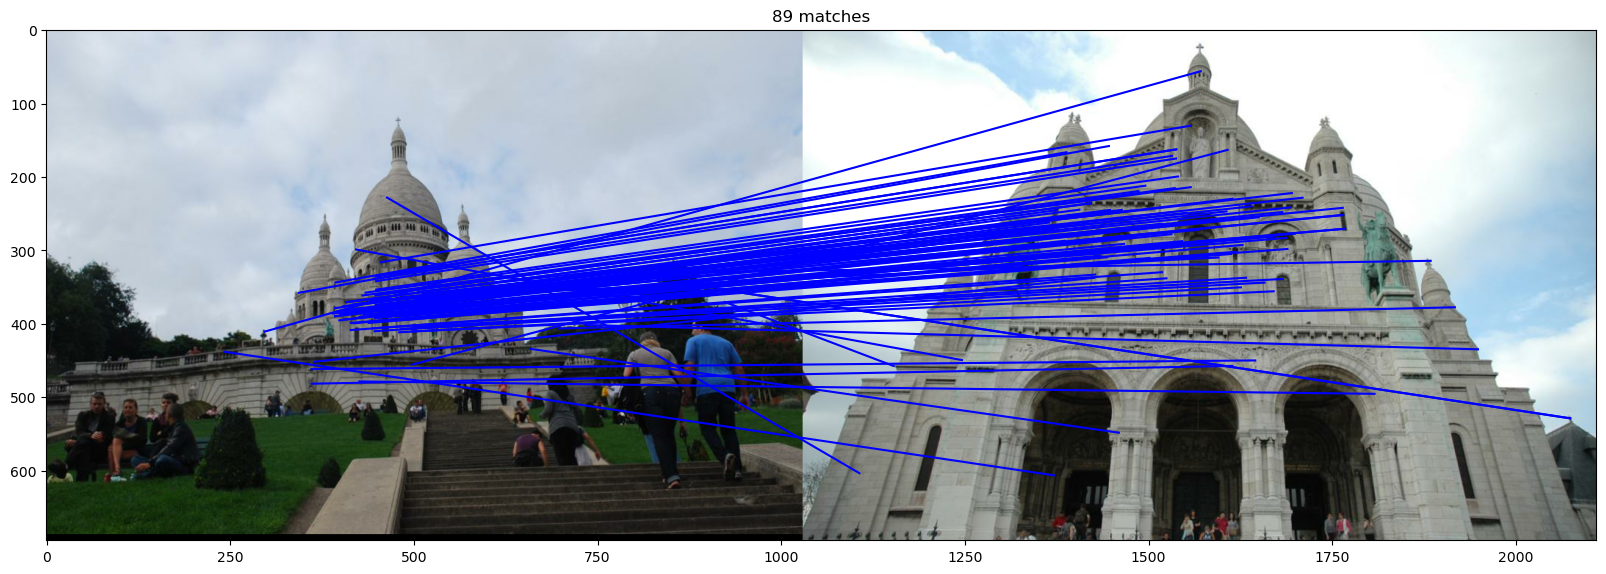

In [3]:
matches = image_pair.matches()
x1, x2 = matches
plotter.set_matches(matches)
plotter.draw()

### Run RelScaleNet

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = RelScaleNetCached("weights/model_final.pth", device)
relscale_pred = model.predict_image_pair(im1_path, im2_path, x1, x2).squeeze()

# Convert relative scale to relative depth
cam1, cam2 = image_pair.cameras()
f1 = cam1['params'][0:2].mean()
f2 = cam2['params'][0:2].mean()
reldepth_pred = f2 / f1 * relscale_pred

Using device: cuda


### Get ground-truth inliers

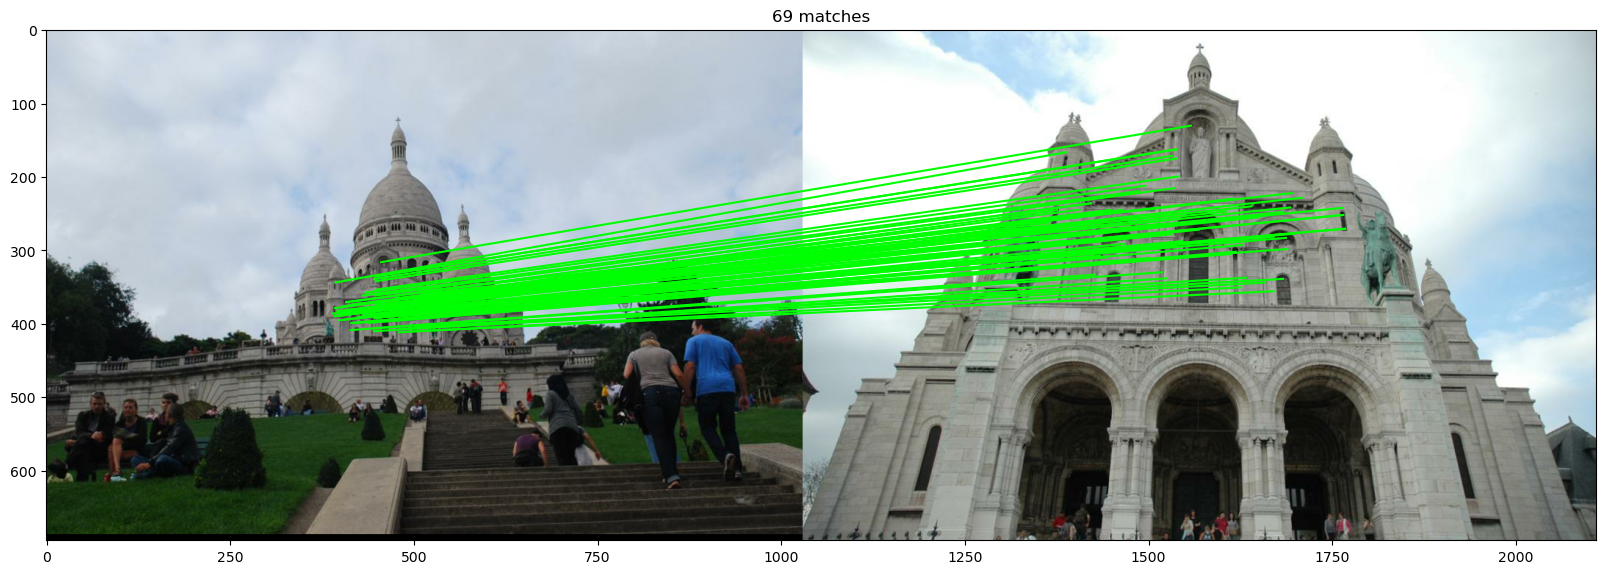

In [5]:
F = image_pair.fundamental_matrix()
err_gt = geometry.sampson_error(F, x1, x2)
inlier_mask = err_gt < INLIER_THRESHOLD

x1_inliers = x1[inlier_mask]
x2_inliers = x2[inlier_mask]
matches_inliers = (x1_inliers, x2_inliers)

plotter.set_matches(matches_inliers)
plotter.draw(color='lime')

### Get ground-truth relative scale on inliers

In [6]:
R_gt, t_gt = image_pair.relative_pose()
K1, K2 = image_pair.calib_matrices()
x1_calib = geometry.calibrate_pts(x1_inliers, K1)
x2_calib = geometry.calibrate_pts(x2_inliers, K2)

X = geometry.triangulate(R_gt, t_gt, x1_calib, x2_calib)
X2 = X @ R_gt.T + t_gt
lambda1 = X[:,2]
lambda2 = X2[:,2]
reldepth_gt = lambda2 / lambda1
relscale_gt = reldepth_gt * f1 / f2

#### Visualize some inlier scale estimates

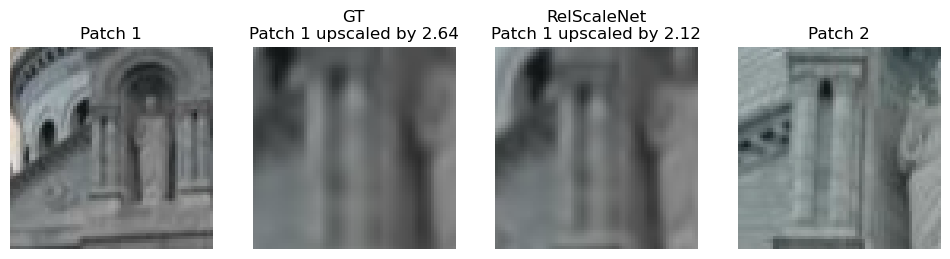

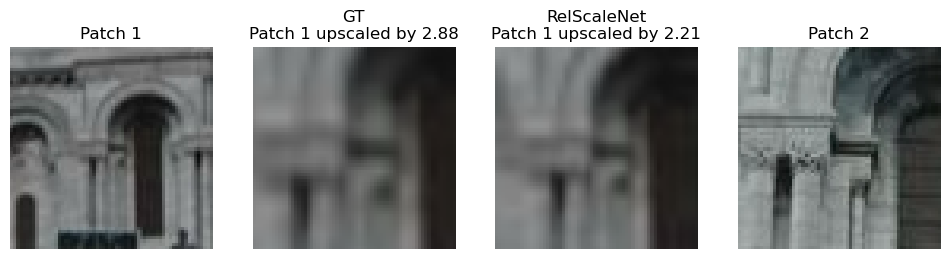

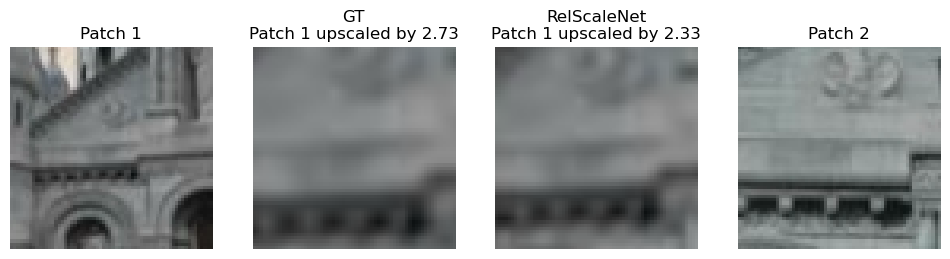

In [7]:

def convert_pytorch_to_numpy(tensor):
        """_summary_

        Args:
            tensor (float32-tensor): (C, H, W) or (1, C, H, W) RGB image

        Returns:
            (float32-array): (H, W, C) RGB image
        """
        squeezed_tensor = tensor.squeeze()
        numpy_image = squeezed_tensor.numpy()
        channel_last_image = numpy_image.transpose([1, 2, 0])
        return channel_last_image


def rescale(im, scale):
    new_dim = (int(im.shape[0]*scale), int(im.shape[1]*scale))
    return cv2.resize(im, new_dim)


def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w, _ = [ zoom * i for i in img.shape ]
    
    if coord is None:
         cx, cy = (w-1)/2, (h-1)/2
    else:
         cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
               : ]
    
    return img

inlier_relscale_pred = relscale_pred[inlier_mask]

im1, _ = load_image(im1_path)
im2, _ = load_image(im2_path)
im1 = im1.float() / 255.
im2 = im2.float() / 255.

patches1_t = extract_patches(im1, x1_inliers)
patches2_t = extract_patches(im2, x2_inliers)

SAMPLE_INDICES = [0, 5, 10]

for i in SAMPLE_INDICES:


    fig, ax = plt.subplots(1, 4, figsize=(12, 8))

    patch1 = convert_pytorch_to_numpy(patches1_t[i])
    patch2 = convert_pytorch_to_numpy(patches2_t[i])


    ax[0].imshow(patch1)
    ax[0].axis('off')
    ax[0].set_title("Patch 1")

    ax[-1].imshow(patch2)
    ax[-1].axis('off')
    ax[-1].set_title("Patch 2")


    for j, relscale in enumerate([relscale_gt[i], inlier_relscale_pred[i]]):

        estimate = "GT" if j == 0 else "RelScaleNet"

        if relscale < 1:
            scaled_patch = zoom_at(patch1, 1/relscale)
            scaled_title = estimate + f"\nPatch 1 upscaled by {1/relscale:.2f}"
        else:
            scaled_patch = zoom_at(patch2, relscale)
            scaled_title = estimate + f"\nPatch 2 upscaled by {relscale:.2f}"


        ax[1+j].imshow(scaled_patch)
        ax[1+j].axis('off')
        ax[1+j].set_title(scaled_title)

### Run solver

In [8]:
RANSAC_OPT ={
    'max_epipolar_error': 1.5,
    'min_iterations': 1000,
    'max_iterations': 100000,
    'success_prob': 0.9999,
    'dyn_num_trials_mult': 3,
}
BUNDLE_OPT = {
    'loss_scale': 1.0,
    'loss_type': 'TRIVIAL'
}

sol, info = poselib.estimate_relative_pose_w_relative_depth(
    x1,
    x2,
    reldepth_pred,
    cam1,
    cam2,
    RANSAC_OPT,
    BUNDLE_OPT
)

r_err = geometry.rotation_angle(sol.R.transpose() @ R_gt)
t_err = geometry.angle(sol.t, t_gt)

print("Rotation Error:", r_err)
print("Translation Error:", t_err)

Rotation Error: 0.42657881904342415
Translation Error: 0.5356609229997641
